### Imports

In [1]:
%matplotlib inline
import gdax
from api_key import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time
from pprint import pprint

### Function Definitions

In [2]:
from gdax_helpers import *

### Login to GDAX

In [3]:
auth_client = gdax.AuthenticatedClient(KEY,
                                       B64SECRET,
                                       PASSPHRASE)

### Get Account Balances

In [4]:
dfacc = get_account_df(auth_client)
dfacc

,available,balance,hold,id,profile_id
currency,,,,,
USD,130.500056,130.500056,0.0,b515a01b-0a24-41bb-b78f-665816215046,149da018-97df-4526-be06-c6c49a48841f
BTC,0.005663,0.005663,0.0,b5750698-0078-4370-a169-7451e424b11a,149da018-97df-4526-be06-c6c49a48841f
LTC,0.000000,0.000000,0.0,819c8e13-2031-402c-af46-90cdfe4dad57,149da018-97df-4526-be06-c6c49a48841f
ETH,0.125000,0.125000,0.0,97212e94-3f21-48fd-a9dd-f88a8dfbde83,149da018-97df-4526-be06-c6c49a48841f
BCH,0.000000,0.000000,0.0,3cd75c2b-8e42-4c35-b741-59f211c06ed9,149da018-97df-4526-be06-c6c49a48841f


### Get account histories

In [5]:
dfhist = get_history_df(auth_client, dfacc)
dfhist

amount     balance         id      type  \
    created_at                                                                
USD 2017-12-29 19:55:45.332484  130.000000  130.500056  593771642  transfer   
    2017-12-20 00:14:53.193794 -100.000000    0.500056  542846699     match   
    2017-12-19 22:37:14.513654   -0.248130  100.500056  542506285       fee   
    2017-12-19 22:37:14.513654  -99.251814  100.748186  542506283     match   
    2017-12-16 02:19:20.795840  100.000000  200.000000  518438320  transfer   
    2017-12-15 19:10:11.993755  100.000000  100.000000  517409156  transfer   
BTC 2017-12-19 22:37:14.513654    0.005663    0.005663  542506282     match   
ETH 2017-12-20 00:14:53.193794    0.125000    0.125000  542846698     match   

                                                            order_id  \
    created_at                                                         
USD 2017-12-29 19:55:45.332484                                   NaN   
    2017-12-20 00:14:53.193794  e51fee2c-48ff-4c31-b20d-4a917c887cfd   
    2017-12-19 22:37:14.513654  d5b23cab-4414-48ee-9d2d-4d3c599e14fc   
    2017-12-19 22:37:14.513654  d5b23cab-4414-48ee-9d2d-4d3c599e14fc   
    2017-12-16 02:19:20.795840                                   NaN   
    2017-12-15 19:10:11.993755                                   NaN   
BTC 2017-12-19 22:37:14.513654  d5b23cab-4414-48ee-9d2d-4d3c599e14fc   
ETH 2017-12-20 00:14:53.193794  e51fee2c-48ff-4c31-b20d-4a917c887cfd   

                               product_id  trade_id  \
    created_at                                        
USD 2017-12-29 19:55:45.332484        NaN       NaN   
    2017-12-20 00:14:53.193794    ETH-USD  22481382   
    2017-12-19 22:37:14.513654    BTC-USD  29043690   
    2017-12-19 22:37:14.513654    BTC-USD  29043690   
    2017-12-16 02:19:20.795840        NaN       NaN   
    2017-12-15 19:10:11.993755        NaN       NaN   
BTC 2017-12-19 22:37:14.513654    BTC-USD  29043690   
ETH 2017-12-20 00:14:53.193794    ETH-USD  22481382   

                                                         transfer_id  \
    created_at                                                         
USD 2017-12-29 19:55:45.332484  3a693eb3-795b-48ce-b4f2-b524e70cb860   
    2017-12-20 00:14:53.193794                                   NaN   
    2017-12-19 22:37:14.513654                                   NaN   
    2017-12-19 22:37:14.513654                                   NaN   
    2017-12-16 02:19:20.795840  01e81d9b-e2c2-49b7-aa3d-5bce23d37079   
    2017-12-15 19:10:11.993755  7edea862-99f4-4c39-93bb-e81c68c2e676   
BTC 2017-12-19 22:37:14.513654                                   NaN   
ETH 2017-12-20 00:14:53.193794                                   NaN   

                               transfer_type     payment  
    created_at                                            
USD 2017-12-29 19:55:45.332484       deposit         NaN  
    2017-12-20 00:14:53.193794           NaN         NaN  
    2017-12-19 22:37:14.513654           NaN         NaN  
    2017-12-19 22:37:14.513654           NaN         NaN  
    2017-12-16 02:19:20.795840       deposit         NaN  
    2017-12-15 19:10:11.993755       deposit         NaN  
BTC 2017-12-19 22:37:14.513654           NaN  -99.499944  
ETH 2017-12-20 00:14:53.193794           NaN -100.000000

### Get current values

In [6]:
holdings = get_value_df(auth_client, slice_holdings(dfhist))
print(holdings['value'])
holdings

     created_at                
BTC  2017-12-19 22:37:14.513654     74.928759
ETH  2017-12-20 00:14:53.193794    105.520000
Name: value, dtype: float64


,,amount,balance,id,type,order_id,product_id,trade_id,transfer_id,transfer_type,payment,price,value,abs_gain,gain_rate
,created_at,,,,,,,,,,,,,,
BTC,2017-12-19 22:37:14.513654,0.005663,0.005663,542506282,match,d5b23cab-4414-48ee-9d2d-4d3c599e14fc,BTC-USD,29043690,NaN,NaN,-99.499944,13231.12,74.928759,-24.571185,-24.694672
ETH,2017-12-20 00:14:53.193794,0.125000,0.125000,542846698,match,e51fee2c-48ff-4c31-b20d-4a917c887cfd,ETH-USD,22481382,NaN,NaN,-100.000000,844.16,105.520000,5.520000,5.520000


### Get Performance History

In [7]:
h = holdings.iloc[0]
df = get_performance_history(auth_client, h) / (abs(h.payment))
df.info()

found BTC-USD data
from 2017-01-01 17:00:00
to   2018-01-01 16:00:00
Filling from
2018-01-01 16:00:00
to
2018-01-01 23:00:00
storing BTC-USD in prices.h5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313 entries, 2017-12-19 23:00:00 to 2018-01-01 16:00:00
Data columns (total 5 columns):
low       313 non-null float64
high      313 non-null float64
open      313 non-null float64
close     313 non-null float64
volume    313 non-null float64
dtypes: float64(5)
memory usage: 14.7 KB


Text(0.5,1,'BTC')

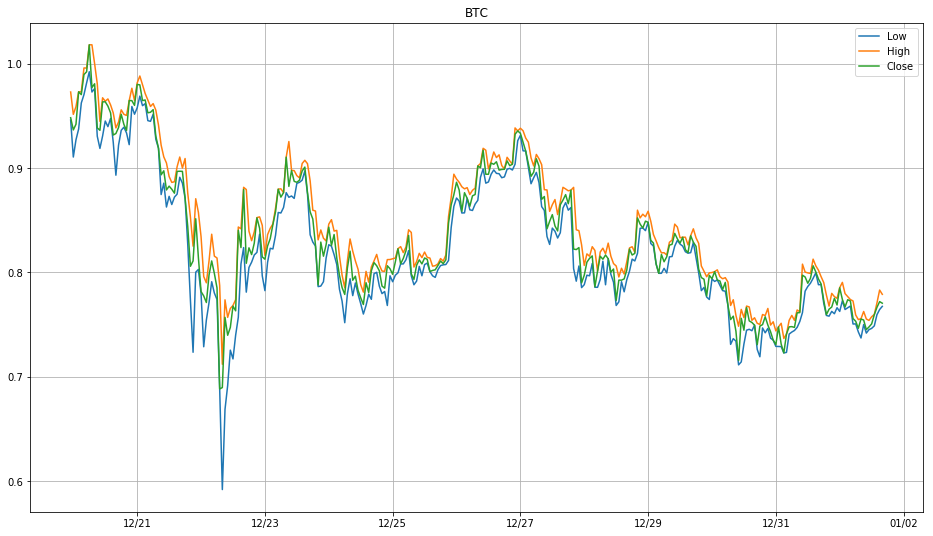

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.grid(True)
ax.plot(df['low'])
ax.plot(df['high'])
ax.plot(df['close'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.legend(['Low', 'High', 'Close'])
ax.set_title(h.name[0])

In [9]:
h = holdings.iloc[1]
df = get_performance_history(auth_client, h) / (abs(h.payment))
df.info()

found ETH-USD data
from 2017-07-05 18:00:00
to   2018-01-01 16:00:00
Filling from
2018-01-01 16:00:00
to
2018-01-01 23:00:00
storing ETH-USD in prices.h5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2017-12-20 01:00:00 to 2018-01-01 16:00:00
Data columns (total 5 columns):
low       311 non-null float64
high      311 non-null float64
open      311 non-null float64
close     311 non-null float64
volume    311 non-null float64
dtypes: float64(5)
memory usage: 14.6 KB


Text(0.5,1,'ETH')

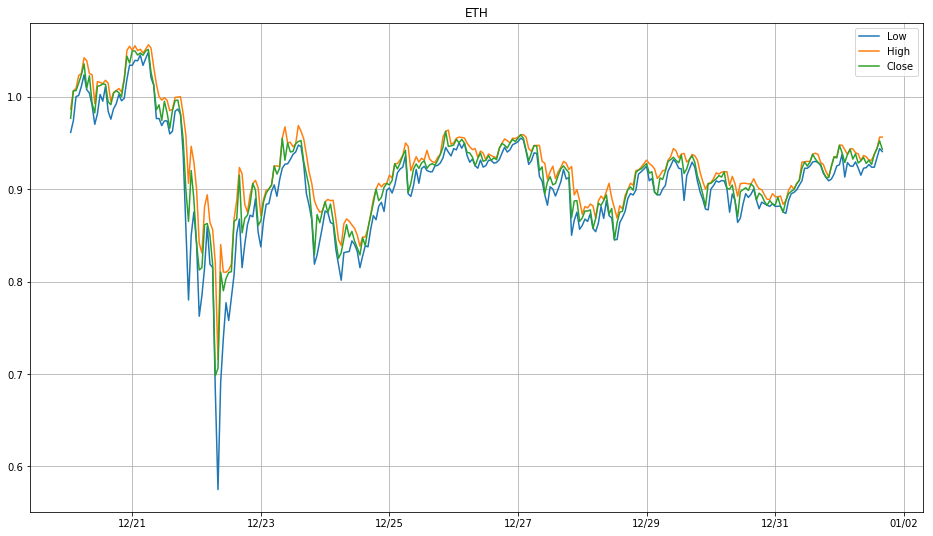

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.grid(True)
ax.plot(df['low'])
ax.plot(df['high'])
ax.plot(df['close'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.legend(['Low', 'High', 'Close'])
ax.set_title(h.name[0])

### Archive Price Data

In [11]:
prod = 'BTC-USD'
d = 365
df = df = get_value_history(auth_client, prod, datetime.now() - timedelta(days=d), gran=timedelta(hours=1))
df.info()

found BTC-USD data
from 2017-01-01 17:00:00
to   2018-01-01 16:00:00
Filling from
2018-01-01 16:00:00
to
2018-01-01 23:00:00
storing BTC-USD in prices.h5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8732 entries, 2017-01-01 17:00:00 to 2018-01-01 16:00:00
Data columns (total 5 columns):
low       8732 non-null float64
high      8732 non-null float64
open      8732 non-null float64
close     8732 non-null float64
volume    8732 non-null float64
dtypes: float64(5)
memory usage: 409.3 KB


(0, 22000)

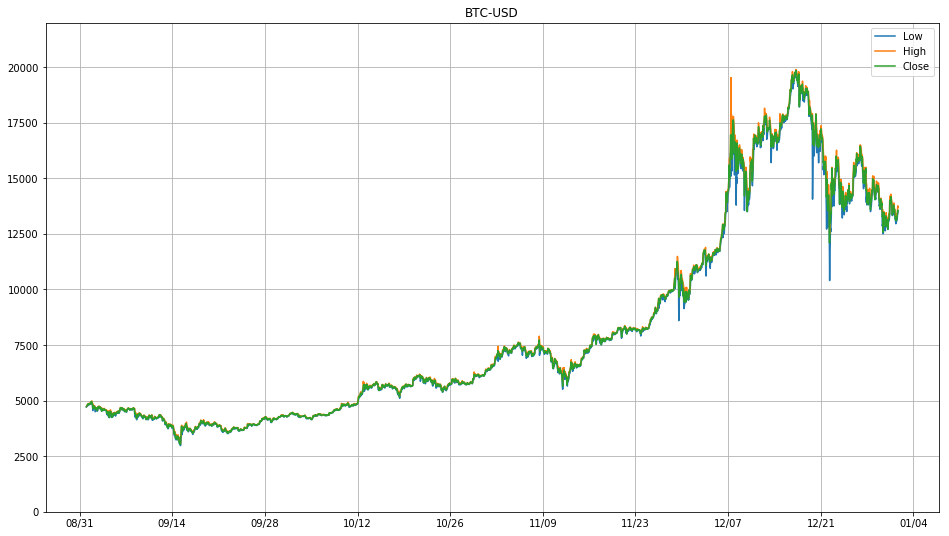

In [12]:
data = df[df.index > datetime(year=2017, month=9, day=1)]
fig, ax = plt.subplots(figsize=(16, 9))
ax.grid(True)
ax.plot(data['low'])
ax.plot(data['high'])
ax.plot(data['close'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.legend(['Low', 'High', 'Close'])
ax.set_title(prod)
ax.set_ylim(0, 22000)

### Scratch